<a href="https://colab.research.google.com/github/mayanku1111/SFprojects/blob/main/W2WSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/kaggle/weights2weights/

/content/drive/MyDrive/kaggle/weights2weights


In [3]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.1 MB/s eta 0:00:00


In [4]:
import os
os.getcwd()

'/content/drive/MyDrive/kaggle/weights2weights'

In [14]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("", "..")))
import torch
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from lora_w2w import LoRAw2w
from utils import load_models, inference, save_model_w2w, save_model_for_diffusers
from inversion import invert
device = "cuda"


In [13]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())

NVIDIA L4


In [15]:
unet, vae, text_encoder, tokenizer, noise_scheduler = load_models(device)

model_index.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
mean = torch.load("/content/drive/MyDrive/kaggle/weights2weights/files/mean.pt").bfloat16().to(device)
std = torch.load("/content/drive/MyDrive/kaggle/weights2weights/files/std.pt").bfloat16().to(device)
v = torch.load("/content/drive/MyDrive/kaggle/weights2weights/files/V.pt").bfloat16().to(device)
weight_dimensions = torch.load("/content/drive/MyDrive/kaggle/weights2weights/files/weight_dimensions.pt")

In [17]:
proj = torch.zeros(1,10000).bfloat16().to(device)
network = LoRAw2w( proj, mean, std, v[:, :10000],
                    unet,
                    rank=1,
                    multiplier=1.0,
                    alpha=27.0,
                    train_method="xattn-strict"
                ).to(device, torch.bfloat16)

In [18]:
network = invert(network=network, unet=unet, vae=vae, text_encoder=text_encoder, tokenizer=tokenizer,
                 prompt = "sks person", noise_scheduler = noise_scheduler, epochs=400,
                 image_path = "/content/drive/MyDrive/kaggle/weights2weights/inversion/images/real_image/real",
                 mask_path = "/content/drive/MyDrive/kaggle/weights2weights/inversion/images/real_image/mask.png", device = device)

100%|██████████| 400/400 [01:20<00:00,  4.94it/s]


In [19]:
#inference parameters
prompt = "sks person"
negative_prompt = "low quality, blurry, unfinished, cartoon"
batch_size = 1
height = 512
width = 512
guidance_scale = 2.5
seed = 1
ddim_steps = 50
# random seed generator
generator = torch.Generator(device=device)

#run inference
image = inference(network, unet, vae, text_encoder, tokenizer, prompt, negative_prompt, guidance_scale, noise_scheduler, ddim_steps, seed, generator, device)

### display image
image = image.detach().cpu().float().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image.show()

100%|██████████| 51/51 [00:03<00:00, 13.46it/s]


100%|██████████| 51/51 [00:03<00:00, 14.16it/s]



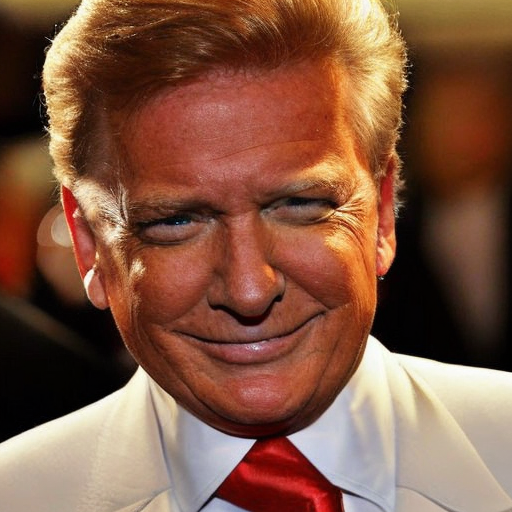

In [20]:
#run inference
image = inference(network, unet, vae, text_encoder, tokenizer, prompt, negative_prompt, guidance_scale, noise_scheduler, ddim_steps, seed, generator, device)

# Convert the image to a format that can be displayed
image = image.detach().cpu().float().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))

# Save the image to a bytes buffer
from io import BytesIO
buffer = BytesIO()
image.save(buffer, format="PNG")
image_bytes = buffer.getvalue()

# Encode the image as base64
import base64
encoded_image = base64.b64encode(image_bytes).decode('utf-8')

# Display the image using HTML
from IPython.display import HTML, display

html_code = f'''
<img src="data:image/png;base64,{encoded_image}" alt="Generated Image">
'''

display(HTML(html_code))

In [21]:
save_model_w2w(network, path="/content/drive/MyDrive/kaggle/weights2weights")